# Sep 15, 2025: test individual partition modes per chain

conda env: gt

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
# import arviz as az
import random
import re

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp-boot'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [6]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f1f880cd7f0>

In [7]:
files = sorted(glob.glob(f'{SBM_path}/boot-01/{SBM}/B-*/desc-partition-modes.pkl', recursive=True))
files

['/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp-boot/model-fits/boot-01/sbm-nd-h/B-1/desc-partition-modes.pkl',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp-boot/model-fits/boot-01/sbm-nd-h/B-112/desc-partition-modes.pkl',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp-boot/model-fits/boot-01/sbm-nd-h/B-224/desc-partition-modes.pkl',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-indi

In [8]:
modes_df = []
for file in tqdm(files):
    match = re.search(r'sbm-([^/]+)/B-(\d+)/', file)
    if match:
        sbm, B = match.groups()
    sbm, B

    with open(f'{file}', 'rb') as f:
        [modes] = pickle.load(f)
    
    M = np.sum([mode.get_M() for mode in modes])
    
    for mode_id, mode in enumerate(modes):
        omega = np.round(mode.get_M() / M, 3)
        sigma = np.round(mode.posterior_cdev(), 3)

        row = pd.DataFrame(dict(
            sub=['grp'],
            sbm=[sbm],
            B=[B],
            mode_id=[mode_id],
            mode=[mode],
            omega=[omega],
            sigma=[sigma],
        ))
        modes_df += [row]
modes_df = pd.concat(modes_df).reset_index(drop=True)

100%|██████████| 5/5 [12:52<00:00, 154.57s/it]


In [9]:
modes_df

,sub,sbm,B,mode_id,mode,omega,sigma
0,grp,nd-h,1,0,<graph_tool.inference.partition_modes.Partitio...,0.177,0.035
1,grp,nd-h,1,1,<graph_tool.inference.partition_modes.Partitio...,0.170,0.042
2,grp,nd-h,1,2,<graph_tool.inference.partition_modes.Partitio...,0.116,0.044
3,grp,nd-h,1,3,<graph_tool.inference.partition_modes.Partitio...,0.097,0.046
4,grp,nd-h,1,4,<graph_tool.inference.partition_modes.Partitio...,0.097,0.045
5,grp,nd-h,1,5,<graph_tool.inference.partition_modes.Partitio...,0.090,0.047
6,grp,nd-h,1,6,<graph_tool.inference.partition_modes.Partitio...,0.066,0.056
7,grp,nd-h,1,7,<graph_tool.inference.partition_modes.Partitio...,0.056,0.064
8,grp,nd-h,1,8,<graph_tool.inference.partition_modes.Partitio...,0.053,0.065
9,grp,nd-h,1,9,<graph_tool.inference.partition_modes.Partitio...,0.044,0.063


In [10]:
Ems = []
for B, group in modes_df.groupby('B'):
    Em = np.exp(stats.entropy(group['omega']))
    Ems += [(B, Em)]
Ems

[('1', np.float64(9.736043259116157)),
 ('112', np.float64(1.0)),
 ('224', np.float64(8.989847523542638)),
 ('335', np.float64(9.510736344716218)),
 ('446', np.float64(1.0))]

In [11]:
def sample_partitions(args, sbms_df):
    all_bs_df = []
    for idx, row in tqdm(sbms_df.iterrows()):
        bs = random.sample(
            list(row['mode'].get_partitions().values()), 
            row['num_samples']
        )
        mode_ids = [idx]*len(bs)
        df = pd.DataFrame(dict(
            mode_id=mode_ids,
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

def sample_nested_partitions(args, sbm_dfs):
    all_bs_df = []
    for idx, row in tqdm(sbm_dfs.iterrows()):
        bs = random.sample(
            list(row['mode'].get_nested_partitions().values()), 
            row['num_samples']
        )
        # bs = [gt.nested_partition_clear_null(b) for b in bs]
        mode_ids = [idx]*len(bs)
        df = pd.DataFrame(dict(
            mode_id=mode_ids,
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

In [12]:
sbms_df = modes_df
args.total_samples = 10000
sbms_df['num_samples'] = sbms_df['omega'].apply(lambda x: np.round(x * args.total_samples).astype(int))
if args.sbm in ['m', 'a', 'd', 'o']:
    all_bs_df = sample_partitions(args, sbms_df)
if args.sbm in ['h']:
    all_bs_df = sample_nested_partitions(args, sbms_df)

34it [00:02, 16.68it/s]


In [13]:
pmode = gt.PartitionModeState(all_bs_df['b'], relabel=True, nested=args.nested, converge=False)
ent_diff = -np.inf
while ent_diff < 1e-10:
    ed = pmode.replace_partitions()
    print(ed)
    if np.isclose(ed, ent_diff, rtol=1e-10):
        break
    ent_diff = ed

if args.sbm in ['m', 'a', 'd', 'o']:
    bs = pmode.get_partitions()
if args.sbm in ['h']:
    bs = pmode.get_nested_partitions()
bs = {k:v for k, v in sorted(bs.items())}
all_bs_df['b_aligned'] = list(bs.values())

-9448.86721229837
-4785.274711554245
-29884.785171147098
-7378.5524326163195
-316.2038386408504
-17.467352670676064
-4.025915467811956
-19.049678848767527
-58.76712778061005
-37.05091810476567
-20.249649197123816
-2.3294227879451768
-0.10366352478023089
-3.97395352536023e-06
-3.97395352536023e-06


In [14]:
cmode = gt.ModeClusterState(all_bs_df['b_aligned'], nested=args.nested, relabel=False)

In [15]:
gt.mcmc_equilibrate(cmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf), verbose=True)

niter:     1  count:    0  breaks:  1  min_S: 2535253.5  max_S: 2535253.5  S: 2535253.5  ΔS:      0.00000  moves:     0 
niter:     2  count:    0  breaks:  1  min_S: 2225105.1  max_S: 2535253.5  S: 2225105.1  ΔS:     -310148.  moves: 302154 
niter:     3  count:    0  breaks:  1  min_S: 2199944.5  max_S: 2535253.5  S: 2199944.5  ΔS:     -25160.7  moves: 70410 
niter:     4  count:    0  breaks:  1  min_S: 2192775.4  max_S: 2535253.5  S: 2192775.4  ΔS:     -7169.04  moves:   598 
niter:     5  count:    0  breaks:  1  min_S: 2186682.1  max_S: 2535253.5  S: 2186682.1  ΔS:     -6093.32  moves:   587 
niter:     6  count:    0  breaks:  1  min_S: 2126330.2  max_S: 2535253.5  S: 2126330.2  ΔS:     -60351.9  moves: 78177 
niter:     7  count:    0  breaks:  1  min_S: 2049741.8  max_S: 2535253.5  S: 2049741.8  ΔS:     -76588.4  moves: 132355 
niter:     8  count:    0  breaks:  1  min_S: 2038685.9  max_S: 2535253.5  S: 2038685.9  ΔS:     -11055.9  moves: 28281 
niter:     9  count:    0  bre

(1508402.434455188, 48608564, 3245866)

In [16]:
def get_pi_matrix(args, mrgnls):
    num_comms = np.max([len(mrgnl) for mrgnl in mrgnls])
    pi = np.zeros((len(mrgnls), num_comms))

    for idx_node, mrgnl in enumerate(mrgnls):
        mrgnl = np.array(mrgnl)
        pi[idx_node, np.where(mrgnl)[0]] = mrgnl[mrgnl > 0]

    pi = pi / np.expand_dims(pi.sum(axis=-1), axis=-1)
    return pi # marginals matrix

def catalog_indiv_modes(args, cmode, g, sub):
    cmode.relabel(maxiter=1000)
    modes = cmode.get_modes()
    pis = [get_pi_matrix(args, mode.get_marginal(g))  for mode in modes]
    M = np.sum([mode.get_M() for mode in modes])
    omegas = [mode.get_M() / M for mode in modes]
    sigmas = [mode.posterior_cdev() for mode in modes]
    subs = [sub]*len(omegas)
    sbms = [args.SBM]*len(omegas)
    modes_df = pd.DataFrame(dict(sub=subs, sbm=sbms, mode_id=np.arange(len(pis)), mode=modes, pi=pis, omega=omegas, sigma=sigmas))
    return modes_df

In [17]:
args.SBM = SBM
df = catalog_indiv_modes(args, cmode, g, 'grp')
df

,sub,sbm,mode_id,mode,pi,omega,sigma
0,grp,sbm-nd-h,0,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.17424,0.037067
1,grp,sbm-nd-h,1,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.14706,0.032846
2,grp,sbm-nd-h,2,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.12018,0.045536
3,grp,sbm-nd-h,3,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.10510,0.056083
4,grp,sbm-nd-h,4,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.09830,0.039077
5,grp,sbm-nd-h,5,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.09346,0.044456
6,grp,sbm-nd-h,6,<graph_tool.inference.partition_modes.Partitio...,"[[0.9990730011587485, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.08630,0.069018
7,grp,sbm-nd-h,7,<graph_tool.inference.partition_modes.Partitio...,"[[0.9997280391623606, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.07354,0.039398
8,grp,sbm-nd-h,8,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.04624,0.058356
9,grp,sbm-nd-h,9,<graph_tool.inference.partition_modes.Partitio...,"[[0.9727891156462585, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.02940,0.069874


In [18]:
np.exp(stats.entropy(df['omega']))

np.float64(9.699070863525858)

<Axes: xlabel='mode_id', ylabel='omega'>

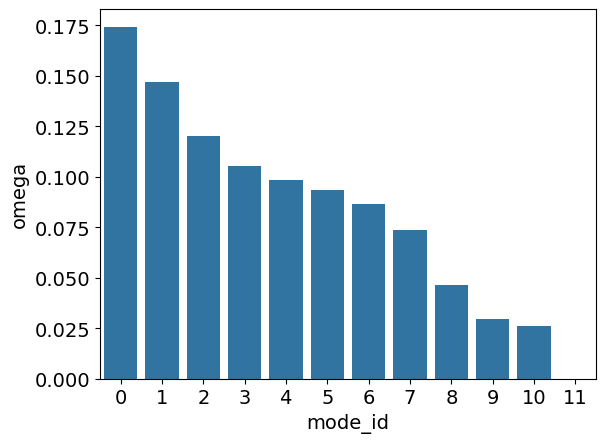

In [19]:
sns.barplot(df, x='mode_id', y='omega')